# Regressão de Séries temporais utilizando redes recorrentes

Uma série temporal pode ser definida como uma coleção de observações feitas sequencialmente ao longo do tempo. Em outras palavras, trata-se de uma informação dinâmica onde padrões que ocorreram no passado podem influenciar no futuro.

Abaixo, apresento uma série temporal qualquer, onde o eixo das abscissas é o tempo e o das ordenadas é uma grandeza medida:

![st](https://user-images.githubusercontent.com/32513366/72760899-03fb2280-3bb9-11ea-9c55-40733335d183.gif)

Nesta prática, o problema será:

**Predição de valores futuros de uma série temporal a partir de valores passados**

Para isso usarei uma Rede Recorrente ou *Recurent Neural Networks* (RNN). Este modelo é um tipo de algoritmo de *Deep Learning*, que apresenta como maior característica o aprendizado ao longo do tempo. Em outras palavras, ele consegue aprender relações dinâmicas.

De forma geral, neste notebook você irá aprender:

- Como fazer pré-processamento para treinamento de modelos recorrentes
- Terminologias de redes neurais: *batch*, *epoch* e *iterations*
- Teoria geral sobre RNN
- Teoria e aplicação de LSTM(*Long-Short Term Memory*) e GRU(*Gated Recurrent Unit*), ambas variações de RNN
- O que é Transferência de aprendizado (*Transfer Learning*) e como aplica-lo

Vale ressaltar que este material foi baseado em diversos conteúdos encontrados de forma gratuita na internet, em inglês. Para mais informações veja a aba **Referências**.

# Módulos

In [1]:
# Biblioteca básica do python
import numpy as np
import pandas as pd
# Para etapa de pré-processamento
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Para o desenvolvimento dos modelos de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
# Para fazer alguns gráficos caso necessário
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Definir semente para reprodutibilidade
np.random.seed(1206)

# Parte 1: Importando os dados

Para este estudo, serão utilizadas duas séries temporais distintas
- **Histórico de ações da Apple Inc.**
- **Produção de leite mensal**

Dado ao foco deste trabalho ser principalmente o aprendizado da teoria e aplicação de RNN, as unidades não irão importar tanto visto que os bancos de dados são relativamente pequenos.

In [3]:
# Importando banco de dados
data_apple = pd.read_csv('./dados/apple_prices.csv', names=['preco'], header=None)
data_leite = pd.read_csv('./dados/monthly-milk-production-pounds.csv')

# Corrigindo alguns detalhes dos bancos de dados
data_leite = data_leite[0:168]
data_leite.columns = ['mes', 'producao']

In [4]:
# Tornando as colunas em arrays de dimensão (N,1)
producao = data_leite['producao'].values.reshape((-1,1))
preco = data_apple['preco'].values.reshape((-1,1))

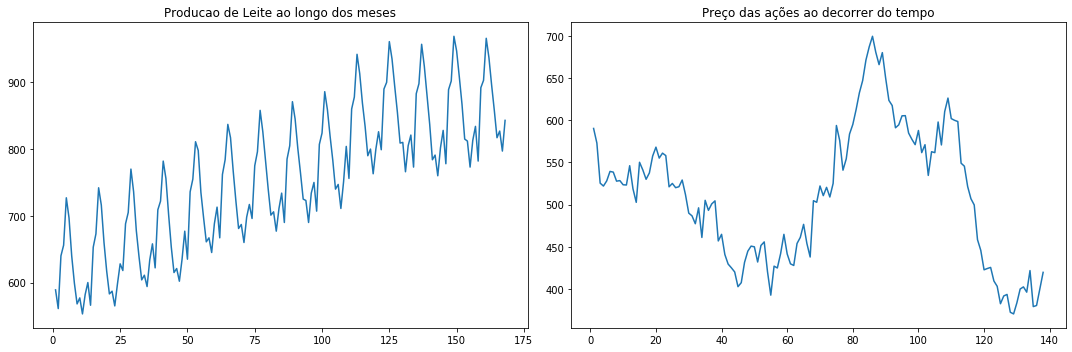

In [5]:
# Fazer os gráficos de ambas as séries
## Declarar eixos e a figura
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
## Plot producao de leite
ax1.set_title('Producao de Leite ao longo dos meses')
ax1.plot(list(range(1,len(producao)+1)),list(producao.reshape(-1)));
## Plot preços da Apple
ax2.set_title('Preço das ações ao decorrer do tempo')
ax2.plot(list(range(1,len(preco)+1)),list(preco.reshape(-1)));
## Comando para melhorar a disposição de cada plot
plt.tight_layout()

Note que ambas as séries apresentam comportamentos distintos. 

O **objetivo** para este notebook será: prever os **20% finais** de cada série utilizando RNN/*Transfer Learning*.

## Parte 2: Pré-processamento dos dados

O pré-processamento dos dados é uma parte essencial para qualquer criação de modelo, seja ele uma *Deep Learning* ou não. Essa etapa garante que ruídos desnecessários ou enganosos não sejam transmitidos considerados. Além disso, é aqui onde ocorre a divisão dos dados em dois conjuntos: treinamento e teste.

Para estas séries temporais, serão feitas as seguintes etapas:
- Hold-out split 80/20
- Padronização Z-Score
- Janelas temporais

### Hold-out split 80/20
Método que consiste na divisão do seu conjunto total de dados em dois: treinamento e teste. O primeiro conjunto é utilizado para treinar os parâmetros do seu modelo. Já o segundo é utilizado para avaliar a qualidade(métricas) do mesmo para informações inéditas.

Note que aqui eu apresento no nome *80/20*, isso implica que 80% dos seus dados serão para treinamento e 20% para teste. Vale ressaltar que existem outras formas de divisão como *70/30* ou *85/15* que seguem a mesma lógica. Sua escolha dependem do usuário e da quantidade de amostras.


In [6]:
# Porcentagem de divisão dos dados
split = 0.80

# Divisão para produção de leite
pSplit = int(split*len(producao))
producao_train = producao[:pSplit] 
producao_test = producao[pSplit:]

# Divisão para preços da Apple
aSplit = int(split*len(preco))
preco_train = preco[:aSplit]
preco_test = preco[aSplit:]

# Print
print('Producão -> Train: ',len(producao_train),' Test: ',len(producao_test))
print('Preço    -> Train: ',len(preco_train),' Test: ',len(preco_test))

Producão -> Train:  134  Test:  34
Preço    -> Train:  110  Test:  28


Um detalhe importante a ser mencionado é o fato de não pegar amostras aleatórias para compor treinamento/teste como é feito usualmente, necessário para não tornar o modelo enviesado, isso ocorre porque estamos lidando com séries temporais, ou seja, a ordem de cada valor é importante para garantir que o modelo adquira corretamente a dinâmica temporal.

**PS**: Caso trabalhe com dados não temporais, o recomendado é pegar amostras aleatórias.

## Padronização Z-score
A padronização Z-score consiste em aplicar para cada amostra a seguinte formula:
![zs](https://user-images.githubusercontent.com/32513366/72865384-6554eb80-3cb6-11ea-831d-6fcf5bfca761.png)

Onde
- *Mi* é a média daquele conjunto
- *Sigma* o desvio padrão daquele conjunto
- *X* o valor amostral
- *Z* o novo valor

Isso é utilizado para padronizar as escalas das variáveis para deixa-las em intervalos equivalentes. Agora nesse momento você deve se perguntar **Por qual razão devo aplicar se apenas temos uma variável em cada conjunto?**

Bom, quando treinamos um modelo neural com valores muito distintos, 10 e 100 por exemplo, é possível que grandes valores tornem a convergência do aprendizado mais lenta ou até mesmo a impeça! Além disso, como as redes fazem diversas somas e multiplicações, valores maiores tendem a pesar muito mais do que os valores menores, algo não desejável. Essa complicação é muito mais evidente em modelos de aprendizado de máquina como K-NN(*K Nearest Neighbours*) ou K Means que utilizam o cálculo de distâncias entre vetores para funcionar.

De qualquer forma, é considerado boa prática aplicar a padronização das variáveis continuas. 

In [7]:
# Producao de Leite
## Declare o objeto para o processo de padronizacao
sspl = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
producao_train = sspl.fit_transform(X = producao_train)

## Transforme o conjunto de test baseado nos parâmetros de train
producao_test = sspl.transform(X = producao_test)

In [8]:
# Preco da Apple
## Declare o objeto para processo de padronizacao
sspa = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
preco_train = sspa.fit_transform(X = preco_train)

## Transforme o conjunto de test baseado nos parâmetros de train
preco_test = sspa.transform(X = preco_test)

Note que apliquei (*fit*) e transformei (*transform*) primeira o conjunto de treino para então depois, utilizando os mesmo parâmetros de média e desvio padrão, transformar o conjunto de teste. Isso é feito para garantir que não ocorra vazamento de informações (*leakage*): momento em que ocorre vazamento de informação fora do conjunto de treinamento para criação do modelo.

Ou seja, caso fosse aplicássemos a padronização em todo o conjunto ocorreria o vazamento de informação do conjunto de teste, que colaboraria para o cálculo de média e desvio padrão.  


## Janelas temporais
Relembrando, uma série temporal se trata de uma sequência de informações que pode ser representada matematicamente da seguinte forma:

$$x_{0},x_{1},x_{2},...,x_{P}$$

Onde $x_{p}$ é o valor numérico daquela variável no período $p$ e $P$ é o tamanho total daquela série.

Para aplicar o modelo de RNN, o problema de predição temporal será tratado como um problema de regressão e para isso precisamos aplicar a ideia de **janela móvel** para construir conjuntos de entrada/saída. Abaixo apresento uma exemplificação do que foi dito: 

![timeseries_windowing_training](https://user-images.githubusercontent.com/32513366/72760895-02315f00-3bb9-11ea-8db9-37dfe8fc1532.gif)

Ao aplicar a janela móvel será necessário definir:
- Tamanho da janela de entrada: quantas amostras passadas serão usadas para prever a saída
- Passo: Qual o passo no tempo que será usado para criar as janelas

No exemplo acima, o tamanho da janela temporal é 5 e o passo utilizado 1. Sua saída pode ser demostrada abaixo:

$$\begin{array}{c|c}
\text{Entrada} & \text{Saida}\\
\hline \color{Red} {\langle x_{1},x_{2},x_{3},x_{4},x_{5}\rangle} & \color{Goldenrod}{ x_{6}} \\
\ \color{Red} {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & \color{Goldenrod} {x_{7} } \\
\color{Red}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{Red} { \langle x_{P-5},x_{P-4},x_{P-3},x_{P-2},x_{P-1} \rangle } & \color{Goldenrod} {x_{P}}
\end{array}$$

Vale ressaltar que considerando uma série de tamanho $P$ e uma janela de tamanho $T$ será gerado ao final $P-T$ pares de entrada/saída.

Diversos códigos podem ser criados de forma manual, porém a biblioteca ```Keras``` já possui uma função que faz isso de forma mais simples em apenas uma linha.

In [9]:
# Tamanho da janela temporal utilizada para prever o valor futuro
window_size = 3

# Tamanho do batch
n_batchs = 3

In [10]:
# Criação das séries para producao
producao_train_sequence = TimeseriesGenerator(data=producao_train,
                                              targets=producao_train,
                                              length=window_size,
                                              batch_size=n_batchs)
producao_test_sequence = TimeseriesGenerator(data=producao_test,
                                              targets=producao_test,
                                              length=window_size,
                                              batch_size=1)

In [11]:
# Criação das séries para preço
preco_train_sequence = TimeseriesGenerator(data=preco_train,
                                           targets=preco_train,
                                           length=window_size,
                                           batch_size=n_batchs)
preco_test_sequence = TimeseriesGenerator(data=preco_test,
                                          targets=preco_test,
                                          length=window_size,
                                          batch_size=1)

Note que é necessário definir ```batch_size```, referente ao termo *batch size*. Ele, junto com *epoch* e *iterations* são bem recorrentes nessa área e valem ser mencionados aqui:
- **batch size**: quantidade de amostras de treinamento usadas para uma ida/retorno.
- **epoch**: quantidade de vezes que seu modelo verá todas as amostras de treinamento no processo de ida e retorno.
- **iterations**: quantidade de ida/retorno, em outras palavras, quantas vezes serão atualizados os pesos da sua rede. Esse valor está intrínseco ao tamanho do **batch size**.

Considere o termo **ida/retorno** como a propagação de informação pela rede (ida) e o aprendizado dos parâmetros da rede a partir do erro avaliado (retorno).

Para tornar esses termos mais factíveis, vamos a um exemplo: considere um conjunto de treinamento de 1000 amostras. Posso definir meu *batch* com o tamanho de 10 amostras e 50 *epochs*. Então baseado nesse exemplo poderei afirmar:
- Cada *epoch* irá conter 100 *iterations*
- Será necessário 10 amostras (um *batch*) para os pesos da rede serão alterados de acordo ao erro avaliado (média dos erros de cada amostra).
- Uma amostra irá ser vista pelo modelo 50 vezes.

# Parte 2: Teoria geral de RNN

Considere uma célula recorrente equivalente a uma célula (neurônio) de uma rede neural normal. A maior diferença reside na **retroalimentação da saída** como entrada para um estado futuro. Para exemplificar, veja a imagem abaixo: 

![rnnLayer](https://user-images.githubusercontent.com/32513366/72867535-098e6080-3cbe-11ea-8163-6b533494e5fc.png)

A seta de retroalimentação é comumente chamada de $hidden state$. 

Em termos mais simples para o período $p$ no tempo, a entrada de uma célula RNN será composta por {$x_{t}, h_{t-1}$} onde $h_{t-1}$ é a saída para a entrada $x_{t-1}$. A visão interna dela pode ser vista abaixo:

![RNN_Core2](https://user-images.githubusercontent.com/32513366/72867934-427b0500-3cbf-11ea-8b5d-85eed84c8b5b.png)

Todavia este modelo de célula sofre um problema chamado *Vanishing gradient* que é quando modelos neurais profundos não conseguem propagar as informações durante o *backpropagation* para as camadas mais próximas da entrada, impedindo assim o aprendizado correto. Diversas técnicas foram lançadas para resolver essa questão, mas não entrarei em detalhes aqui. 

O importante a ressaltar aqui é que dado este problema, a RNN sofre muitas vezes de uma memória curta sendo incapaz de lembrar de informações mais antigas. Para sanar essa dificuldade, outras arquiteturas de células foram propostas: LSTM e GRU.

## Proposta da prática

Dando continuidade a criação prática dos modelos, inicialmente serão gerados dois modelos para o banco de dados de produção de leite:
- LSTM
- GRU

Após avaliar a arquitetura com melhor resultado, utilizando a prática de *Transfer Learning*, será criado um novo modelo para o histórico de ações, concluindo assim este notebook.

# Parte 3: Criando a Rede Recorrente LSTM

A LSTM é uma sigla para *Long-Short Term Memory* e se trata de uma arquitetura capaz de manter informações a longo prazo. Sua célula é exposta abaixo:

![LSTM ORIG1](https://user-images.githubusercontent.com/32513366/73123983-98c49e00-3f74-11ea-92b8-c0ec6ea39481.png)

Apesar de parecer complexo, vamos quebrar a explicação do seu funcionamento por partes.

Primeiro, cada termo representa:
- **$C$** é chamado de Estado da célula (*Cell State*)
- **$h$** é chamado de Estado escondido (*Hidden State*)
- **$x$** é basicamente a entrada daquela camada, seja ela a entrada da rede ou a saída de uma camada anterior (caso tenha mais de uma camada escondida)

O estado temporal é demonstrado por:
- **$t-1$** se refere ao estado temporal anterior
- **$t$** se refere ao estado temporal atual

A explicação para cada termo é a seguinte:
- *Cell State* funciona como uma memória geral daquela célula, armazenando informações dos períodos temporais. Sua informação é controlada pelos portões (*gates*), explicados mais a frente.
- *Hidden State* é a saída para aquele estado temporal, ou seja, dado um $x_{t}$ teremos um $h_{t}$ correspondente.

Agora, antes de eu entrar na explicação propriamente dita, vamos a algumas observações:
- Para a arquitetura de célula LSTM, a retroalimentação da célula é composta por: **$C$** e **$h$**.
- Cada **entrada na célula assim como cada portão** a ser explicado possui pesos referenciados a eles, mais precisamente as funções *sigmoid*/*tanh* apresentadas em amarelo. Estes pessos serão treinados no decorrer do aprendizado da rede como todos os outros.

**PS**: Essa última informação é válida para qualquer célula de RNN, como a GRU.

Agora vamos as explicações dos famosos portões, onde destaquei cada um em vermelho (referenciada na parte de **Referências** deste notebook):

![LSTM_ALL](https://user-images.githubusercontent.com/32513366/73124231-b34c4680-3f77-11ea-99af-149a8c62e2cd.png)

- **(1)**: Chamado de *Forget Gate* ou Portão do Esquecimento sua função é avaliar, baseado na entrada concatenada {$x_{t}$ + $h_{t-1}$}, quanta informação do $C_{t-1}$ será mantida para o novo estado de memória $C_{t}$. Para isso, a ativação é realizada por uma *sigmoid*, que pode ser analisada em termos de porcentagem no intervalo de 0 a 1. Para ativações próximas a um (100%) estaria sendo transmitido, considerando a informação atual $x_{t}$ e o estado anterior $h_{t-1}$, a informação de manter totalmente o estado de memória anterior $C_{t-1}$ para o novo estado, já para valores próximos a zero (0%) estaria sendo transmitido o oposto: esquecer aquele estado anterior $C_{t-1}$.
- **(2)**: Chamado de *Input Gate* ou Portão de Entrada possui a função de adicionar nova informação para $C_{t}$ baseado na mesma entrada do *Forget Gate* sendo dividido em duas partes. A primeira parte representada pela *sigmoid* funciona da mesma forma que o portão anterior, ponderando de 0 a 1 o impacto da nova informação a ser inserida em $C_{t}$. Já a segunda parte representada pela *tanh* gera um vetor de candidato $K_{t}$ para compor o novo estado de memória $C_{t}$ ponderado pela parte anterior.
- **(3)**: Não se trata propriamente de um portão, mas sim da atualização/criação do novo estado de memória $C_{t}$. Inicialmente, ponderado pelo primeiro portão, é esquecido informações antigas de $C_{t-1}$ baseadas no novo conjunto de informações {$x_{t}$ + $h_{t-1}$}. Em seguida, a nova informação gerada pelo segundo portão é adicionada ao estado de memória, criando assim o $C_{t}$ para aquele momento no tempo $t$.
- **(4)**: Chamado de *Output Gate* ou Portão de Saída, sua função é gerar o novo estado escondido $h_{t}$. Apresentando um funcionamento semelhante ao Portão de Entrada, a informação que será carregada para o novo estado escondido é ponderada novamente pela concatenação {$x_{t}$ + $h_{t-1}$} transmitida através da *sigmoid* no intervalo de zero a um e o corpo propriamente dito será o estado de memória atual $C_{t}$ calculado, que será tratado pela função *tanh* atualizando assim o novo estado estado escondido $h_{t}$.

Dito, isso algumas informações podem ser ressaltadas a partir desta explicação:
- Em todos os portões, temos a presença da *sigmoid* para avaliar o **quanto** de informação será transmitida para o estado de memória, controlando assim o seu fluxo e consequentemente o estado escondido para o tempo $t$.
- A presença da função *tanh*  é usada para manutenção da informação a longo prazo, evitando o problema *Vanish Gradient*. Ela pode ser substituida pela função *ReLU*.
- Como dito anteriormente, cada ativação apresentada em amarelo possui pesos associados.
- Esse controle é o responsável pela característica de armazenar informações mais antigas, diferente da célula RNN que apenas retroalimentava o estado final para a entrada.

Abaixo, darei continuidade a criação de um modelo recorrente utilizando esta arquitetura:

In [12]:
# Criando objeto do modelo
lstm_model = Sequential(name='LSTM_MODEL')

In [13]:
# Adicionar primeira camada
lstm_model.add(LSTM(units=100,activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
lstm_model.add(LSTM(units=100,activation='relu'))
# Adicionar camada de saida
lstm_model.add(Dense(units=1))

## Adicionando múltiplas camadas internas recorrentes

Para modelos RNN um argumento importante precisa ser definido: ```input_shape``` que é dado da seguinte forma:
```(tamanho_janela_temporal, quantidade_de_features)```
Como temos apenas uma variável, foi definido o valor de um.

Além disso, ao desenvolver um modelo recorrente com duas ou mais camadas de LSTM você notará a presença e necessidade de definir o parâmetro ```return_sequences=True```. Ela é importante para aglomerar várias camadas recorrentes de forma sequencial. Para explicar o motivo, irei explicar seus estados:
- ```return_sequences=False```: Tratado com estado *default*, cada célula presente naquela camada irá retornar apenas o último estado escondido calculado. 
- ```return_sequences=True```: Retorna todos os estados escondidos calculado pela célula.

**PS**: Isso é valido também para a GRU.

Para explicar melhor, vamos usar uma arquitetura de rede como exemplo:

![stacked example](https://user-images.githubusercontent.com/32513366/73180621-6d68bd00-40f4-11ea-844b-339aa98c42b3.png)

A rede apresentada acima apresenta uma janela temporal de entrada com tamanho 5 ${x_{1},x_{2},x_{3},x_{4},x_{5}}$ e duas camadas internas com 3 células cada e uma camada final densa com apenas um neurônio.

Como vimos anteriormente, cada entrada irá gerar um estado escondido correspondente para aquele período em cada célula na primeira camada, ou seja: dado o conjunto de $X$ cada célula irá gerar ${h_{1},h_{2},h_{3},h_{4},h_{5}}$. Isso ocorre dado ao fato da primeira camada estar ligada com a entrada, mas como seria para as camadas subsequentes?

Bom, para manter a temporalidade usa-se a opção ```return_sequences=True```, onde as células iriam retornar todos os estados escondidos como saída, ou seja, ${h_{1},h_{2},h_{3},h_{4},h_{5}}$. Esses estados funcionarão como entrada para a próxima camada escondida. Note que esse conjunto de entrada possui o mesmo tamanho do vetor de entrada $X$, criando asism a aprendizagem profunda.

Já para a opção para ```return_sequences=False```, a célula irá retornar apenas o último estado escondido, no nosso caso $h_{5}$. Essa opção é necessária para fazer a previsão final, ligando as camadas de RNN com as camadas Densas.

Portanto, na figura apresentada as ligações em vermelho são pacotes **singulares**:
- Na ligação da entrada, cada $x_{i}$ representa um estado para um determinado período
- Já na saída, ligando a última camada de RNN com a camada Densa, cada saída da célula é dado pelo seu estado escondido final $h_{c5}$ onde $c$ representa a célula em específico na segunda camada.

As ligações em preto, entre as camadas recorrentes, são pacotes **plurais**:
- Cada célula da primeira camada envia um vetor de saída ${h_{c1},h_{c2},h_{c3},h_{c4},h_{c5}}$ para todas as células da próxima camada. Logo, a entrada de uma célula da segunda camada pode ser vista como: 

${\sum_{c=1}^C h_{c1},\sum_{c=1}^C h_{c2},\sum_{c=1}^C h_{c3},\sum_{c=1}^C h_{c4},\sum_{c=1}^C h_{c5}}$

Onde $C$ é a quantidade de células na primeira camada, sendo assim um **somatório** de estados escondidos.

Para a ligação da última camada recorrente com a densa, irá se tratar, de forma análoga, de um somatório dos últimos estados escondidos de cada célula. 

Dando continuidade ao treinamento e avaliação do modelo LSTM:

In [14]:
# Descrição do modelo
lstm_model.summary()
# Compilar o modelo
lstm_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])
# Treinando o modelo
LSTM_history = lstm_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

Model: "LSTM_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
44/44 - 2s - loss: 0.8311 - mse: 0.8331
Epoch 2/15
44/44 - 1s - loss: 0.5515 - mse: 0.5540
Epoch 3/15
44/44 - 1s - loss: 0.4785 - mse: 0.4811
Epoch 4/15
44/44 - 1s - loss: 0.4208 - mse: 0.4230
Epoch 5/15
44/44 - 1s - loss: 0.3904 - mse: 0.3923
Epoch 6/15
44/44 - 1s - loss: 0.3670 - mse: 0.3684
Epoch 7/15
44/44 - 1s - loss: 0.3297 - mse: 0.3315
Epoch 8/15
44/44 - 1s -

# Parte 4: Criando a Rede Recorrente GRU

A GRU é uma sigla para *Gated Recurrent Unit* e se trata de uma uma arquitetura distinta da LSTM, mas capaz de manter informações a longo prazo. Sua célula é apresentada abaixo:

![GRU ORIG](https://user-images.githubusercontent.com/32513366/73182282-89ba2900-40f7-11ea-95bc-c7812942e0b5.png)

Note que a maior distinção está na ausência do *Cell State* apresentado na LSTM. Aqui, através dos portões o *Hidden State* consegue suplantar seu lugar.

Novamente, cada termo apresentado acima representa:
- **$h$** é chamado de Estado escondido (*Hidden State*)
- **$x$** é basicamente a entrada daquela camada, seja ela a entrada da rede ou a saída de uma camada anterior (caso tenha mais de uma camada escondida)

O estado temporal é demonstrado por:
- **$t-1$** se refere ao estado temporal anterior
- **$t$** se refere ao estado temporal atual

Assim como a LSTM, cada termo representa a mesma coisa e o controle da resposta de cada célula é feita também através dos portões. Vale ressaltar que assim como a LSTM, cada entrada na célula ($h$ e $x$) assim como cada ativação *sigmoid*/*tanh* possui pesos associados. apresentados abaixo:

![GRU_ALL](https://user-images.githubusercontent.com/32513366/73190181-59c55280-4104-11ea-8e51-ba03c6059ddb.png)


- **(1)**: Chamado de *Update Gate* apresenta um funcionamento equivalente ao primeiro portão da LSTM (*Forget Gate*). Basicamente ajuda o modelo a determinar quanto da informação passada precisa ser mantida para o futuro.
- **(2)**: Chamado de *Reset Gate* decide o quanto da informação passada deve ser esquecida. Apesar de parecer equivalente ao primeiro portão, eles se diferenciam de acordo aos pesos associados a eles.
- **(3)**: Resultado da interação do segundo portão com o estado escondido anterior e a entrada no período atual é chamada de *Reurrent Memory Content* e atua na manutenção de informações relevantes do passado para o novo estado $h_{t}$. Essa nova informação é inserida através da ativação com a função *tanh*
- **(4)**: Trata-se da criação do novo estado de memória $h_t$ e não de um novo portão. Aqui a saída do primeiro portão determina o que coletar do novo candidato gerado na interação (3) e a informação restante do estado escondido anterior a ser mantido para gerar o novo estado escondido.

Como apenas ocorre uma mudança de arquitetura, nada de novo precisa ser apresentado em si. A ausência do *Cell State* torna o aprendizado da GRU mais rápido em comparação ao da LSTM.

A criação do modelo usando a arquitetura de célula GRU é apresentado abaixo:

In [15]:
# Criando objeto do modelo
gru_model = Sequential(name='GRU_MODEL')

In [16]:
# Adicionar primeira camada
gru_model.add(GRU(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
gru_model.add(GRU(units=100, activation='relu'))
# Adicionar camada de saida
gru_model.add(Dense(units=1))

# Descrição do modelo
gru_model.summary()

Model: "GRU_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 100)            30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compilar o modelo
gru_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])

In [18]:
# Treinando o modelo
GRU_history = gru_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

Epoch 1/15
44/44 - 2s - loss: 0.6551 - mse: 0.6568
Epoch 2/15
44/44 - 2s - loss: 0.4137 - mse: 0.4162
Epoch 3/15
44/44 - 2s - loss: 0.3482 - mse: 0.3498
Epoch 4/15
44/44 - 2s - loss: 0.2803 - mse: 0.2815
Epoch 5/15
44/44 - 2s - loss: 0.2345 - mse: 0.2352
Epoch 6/15
44/44 - 2s - loss: 0.2278 - mse: 0.2278
Epoch 7/15
44/44 - 2s - loss: 0.2237 - mse: 0.2245
Epoch 8/15
44/44 - 2s - loss: 0.2286 - mse: 0.2291
Epoch 9/15
44/44 - 2s - loss: 0.2208 - mse: 0.2215
Epoch 10/15
44/44 - 2s - loss: 0.2244 - mse: 0.2250
Epoch 11/15
44/44 - 2s - loss: 0.2108 - mse: 0.2112
Epoch 12/15
44/44 - 2s - loss: 0.2237 - mse: 0.2244
Epoch 13/15
44/44 - 2s - loss: 0.2185 - mse: 0.2193
Epoch 14/15
44/44 - 2s - loss: 0.2161 - mse: 0.2167
Epoch 15/15
44/44 - 2s - loss: 0.2117 - mse: 0.2123


# Parte 5: Comparando os resultados

Para avaliar os resultados de qualidade e treinamento dos modelos foi utilizando o *Mean Squared Error* (MSE). Essa métrica indica bons resultados para valores mais próximos a zero e péssimos de forma contrária.

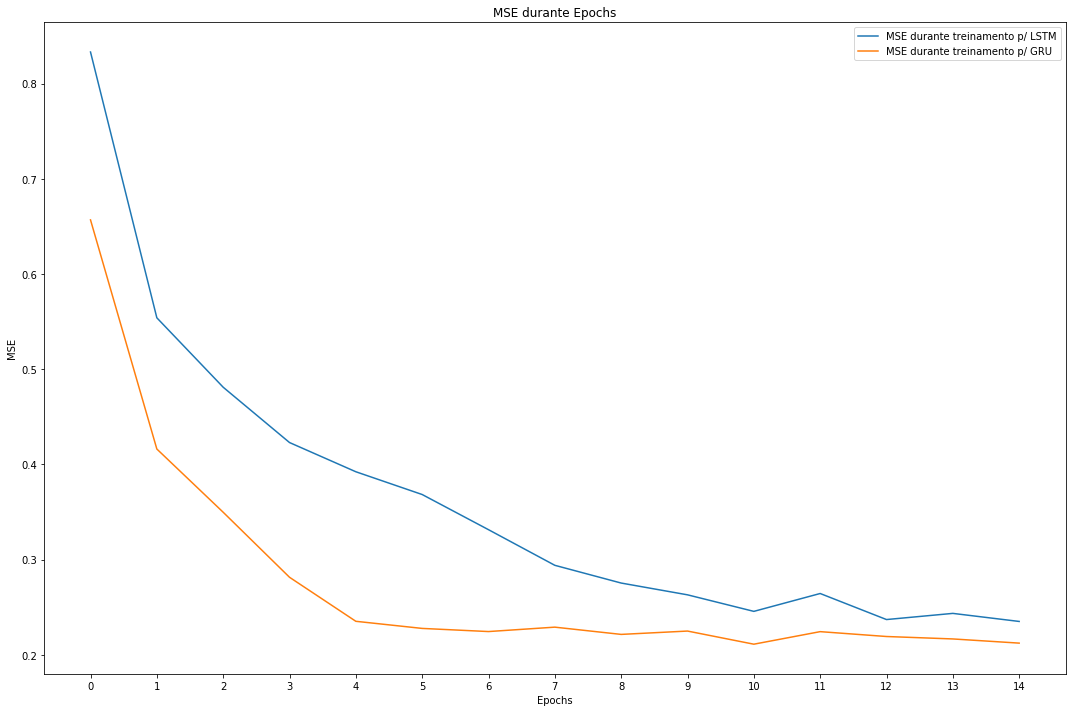

In [19]:
# Plot do treinamento
epochs_range = list(range(0,15))
# Plots
plt.figure(figsize=(15,10));
# Accuracy X Epochs
plt.plot(LSTM_history.history['mse'], label='MSE durante treinamento p/ LSTM')
plt.plot(GRU_history.history['mse'], label='MSE durante treinamento p/ GRU')
plt.title('MSE durante Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.xticks(epochs_range)
plt.legend(loc='upper right')

# Default to improve spaces between the plots
plt.tight_layout()

In [20]:
# Prever valores futuros(validação) com LSTM
LSTM_pred = lstm_model.predict_generator(generator=producao_test_sequence)
# Prever valores futuros(validação) com GRU
GRU_pred = gru_model.predict_generator(generator=producao_test_sequence)

In [21]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(producao_train) + window_size)
xpreds = range(len(producao_train) + window_size, len(producao_train) + len(producao_test))

In [22]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(producao_train.reshape(-1)) + list(producao_test.reshape(-1)[0:window_size])
yv = list(producao_test.reshape(-1))[window_size:]
ypGRU = list(GRU_pred.reshape(-1))
ypLSTM = list(LSTM_pred.reshape(-1))

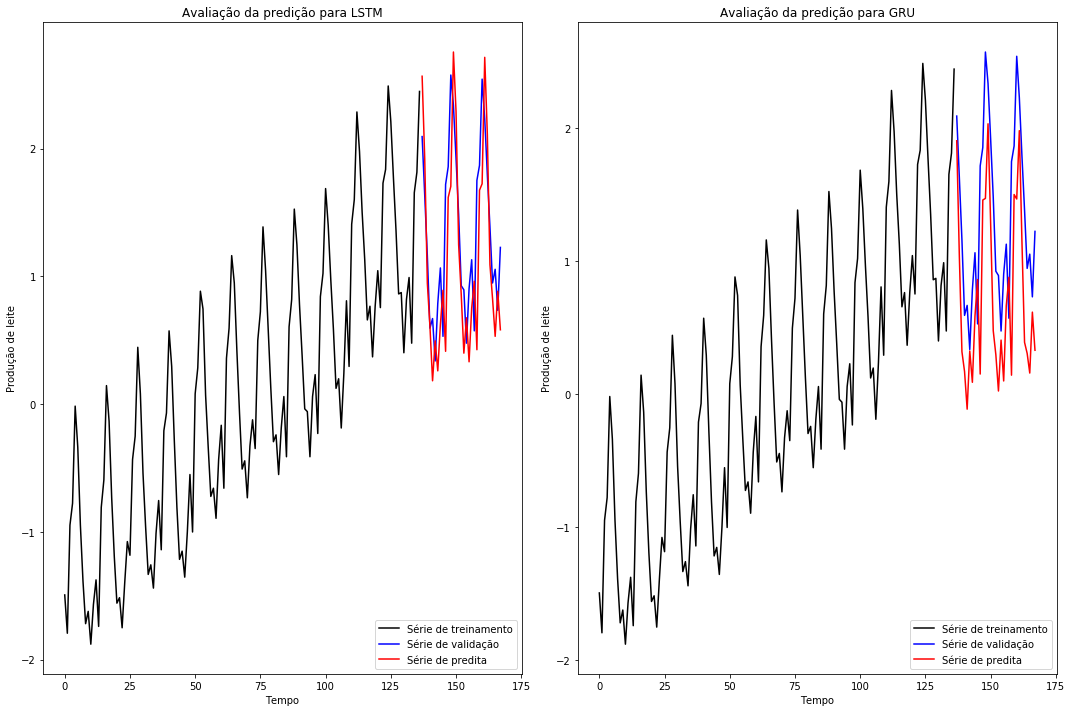

In [23]:
# Plots
fig, ax = plt.subplots(1,2, figsize=(15,10));
# LSTM
ax[0].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[0].plot(xpreds,yv, label='Série de validação', color='blue')
ax[0].plot(xpreds,ypLSTM, label='Série de predita', color='red')  
ax[0].set_title('Avaliação da predição para LSTM')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Produção de leite')
ax[0].legend(loc='lower right')

# GRU
ax[1].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[1].plot(xpreds,yv, label='Série de validação', color='blue')
ax[1].plot(xpreds,ypGRU, label='Série de predita', color='red')  
ax[1].set_title('Avaliação da predição para GRU')
ax[1].set_xlabel('Tempo')
ax[1].set_ylabel('Produção de leite')
ax[1].legend(loc='lower right')
# Default to improve spaces between the plots
plt.tight_layout()

In [24]:
# Avaliar métricas para LSTM
LSTM_metric = lstm_model.evaluate_generator(generator=producao_test_sequence)[1]
print('LSTM alcançou ', LSTM_metric,' de MSE.')

# Avaliar métrica para GRU
GRU_metric = gru_model.evaluate_generator(generator=producao_test_sequence)[1]
print('GRU alcançou ', GRU_metric,' de MSE.')

LSTM alcançou  0.27848792  de MSE.
GRU alcançou  0.5641056  de MSE.


Note que apesar do gráfico de MSE de treinamento ter apresentado a GRU como melhor, através das predições vemos que a LSTM apresenta-se como uma melhor arquitetura.

# Parte 6: Transfer Learning para um novo modelo

Transfer learning ou Transferência de Aprendizado é uma metodologia em machine learning onde um modelo desenvolvido é reutilizado como ponto de inicio para uma segunda tarefa, que pode não ter nenhuma relação com a tarefa original do outro modelo. Em outras palavras, pode ser considerado como uma tentativa de chute inicial mais embasado.

Nesta prática, utilizando irei aplicar esse técnica utilizando os pesos treinados do modelo LSTM anterior para produção de leite para ponto de inicio de outro modelo LSTM para predição de ações da Apple. Para facilitar a aplicação, toda a arquitetura desenvolvida anteriormente será mantida.

## Criação do modelo

In [33]:
# Criando objeto do modelo
ctf_model = Sequential(name='LEITE_MODEL_C_TF')

In [34]:
# Adicionar primeira camada
ctf_model.add(LSTM(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
ctf_model.add(LSTM(units=100, activation='relu'))
# Adicionar camada de saida
ctf_model.add(Dense(units=1))

# Descrição do modelo
ctf_model.summary()

Model: "LEITE_MODEL_C_TF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


## Aplicação da técnica de Transfer Learning

In [35]:
# Aplicando Transfer Learning
ctf_model.layers[0].set_weights(lstm_model.layers[0].get_weights())
ctf_model.layers[1].set_weights(lstm_model.layers[1].get_weights())
ctf_model.layers[2].set_weights(lstm_model.layers[2].get_weights())

## Compilação e treinamento do modelo

In [36]:
# Compilar o modelo
ctf_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])
# Treinando o modelo
CTF_history = ctf_model.fit_generator(preco_train_sequence, epochs=30, verbose=2);

Epoch 1/30
36/36 - 1s - loss: 0.1261 - mse: 0.1254
Epoch 2/30
36/36 - 1s - loss: 0.1092 - mse: 0.1096
Epoch 3/30
36/36 - 1s - loss: 0.1053 - mse: 0.1056
Epoch 4/30
36/36 - 1s - loss: 0.1206 - mse: 0.1209
Epoch 5/30
36/36 - 1s - loss: 0.0990 - mse: 0.0993
Epoch 6/30
36/36 - 1s - loss: 0.1246 - mse: 0.1248
Epoch 7/30
36/36 - 1s - loss: 0.1070 - mse: 0.1074
Epoch 8/30
36/36 - 1s - loss: 0.1137 - mse: 0.1141
Epoch 9/30
36/36 - 1s - loss: 0.1146 - mse: 0.1151
Epoch 10/30
36/36 - 1s - loss: 0.1049 - mse: 0.1053
Epoch 11/30
36/36 - 1s - loss: 0.1027 - mse: 0.1030
Epoch 12/30
36/36 - 1s - loss: 0.1059 - mse: 0.1063
Epoch 13/30
36/36 - 1s - loss: 0.1012 - mse: 0.1014
Epoch 14/30
36/36 - 1s - loss: 0.1070 - mse: 0.1074
Epoch 15/30
36/36 - 1s - loss: 0.0993 - mse: 0.0996
Epoch 16/30
36/36 - 1s - loss: 0.1063 - mse: 0.1066
Epoch 17/30
36/36 - 1s - loss: 0.0903 - mse: 0.0905
Epoch 18/30
36/36 - 1s - loss: 0.1008 - mse: 0.1012
Epoch 19/30
36/36 - 1s - loss: 0.0961 - mse: 0.0964
Epoch 20/30
36/36 - 1

## Avaliação dos resultados

In [37]:
# Prever valores futuros(validação) com GRU para preços da Apple
CTF_pred = ctf_model.predict_generator(generator=preco_test_sequence)

In [38]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(preco_train) + window_size)
xpreds = range(len(preco_train) + window_size, len(preco_train) + len(preco_test))

In [39]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(preco_train.reshape(-1)) + list(preco_test.reshape(-1)[0:window_size])
yv = list(preco_test.reshape(-1))[window_size:]
ypCTF = list(CTF_pred.reshape(-1))

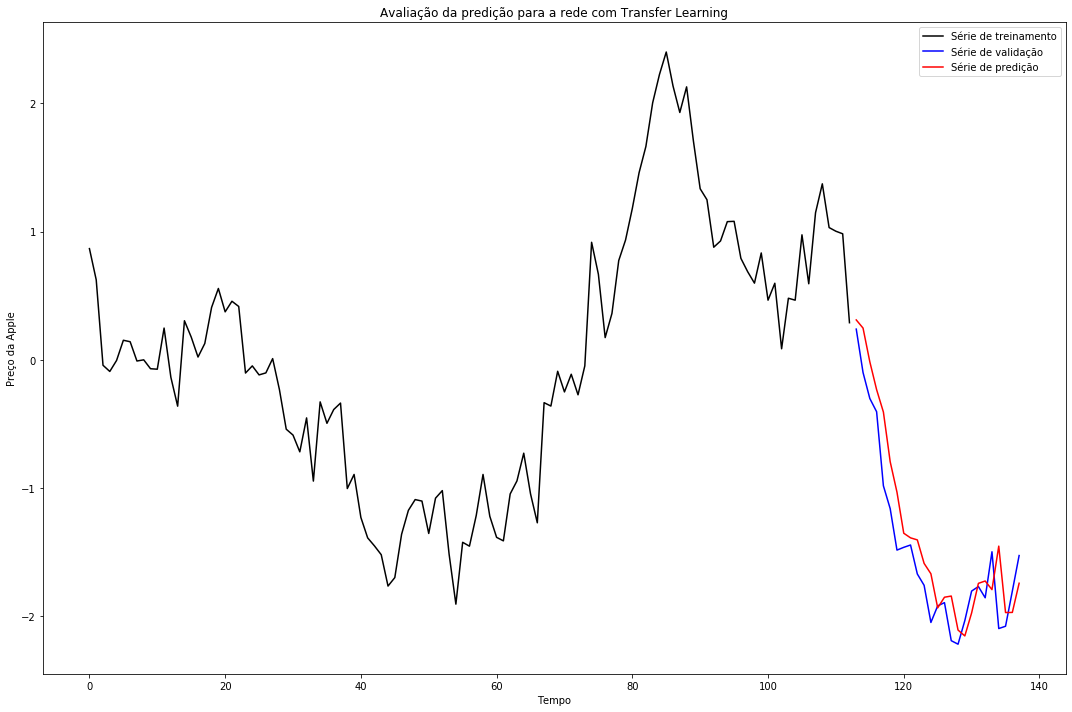

In [40]:
# Plots
fig = plt.figure(figsize=(15,10));
# CTF - Com Transfer Learning
plt.plot(xtrain,yt, label='Série de treinamento', color='black')
plt.plot(xpreds,yv, label='Série de validação', color='blue')
plt.plot(xpreds,ypCTF, label='Série de predição', color='red')  
plt.title('Avaliação da predição para a rede com Transfer Learning')
plt.xlabel('Tempo')
plt.ylabel('Preço da Apple')
plt.legend(loc='upper right')

# Default to improve spaces between the plots
plt.tight_layout()

## Avaliação de métrica

In [41]:
CTF_metric = ctf_model.evaluate_generator(generator=preco_test_sequence)[1]
print('CTF alcançou ', CTF_metric,' de MSE.')

CTF alcançou  0.077960715  de MSE.


# Conclusão

Através deste notebook diversos conteúdos foram destrinchados de forma teórica e prática:
- RNN
- LSTM
- GRU
- Transfer Learning

# Referências

Diversos blogs e documentações foram utilizadas na confecção deste notebook. Caso saiba inglês, a leitura é bastante recomendada:

- [Difference between batch and epoch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
- [Keras Time Series Generator function](https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)
- [Time Series forecasting with RNN](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)
- [LSTM for Time Series forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
- [Illustrated Guide to LSTM's and GRU's Video](https://www.youtube.com/watch?v=8HyCNIVRbSU)
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Transfer Learning for deep learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
- [Stacked Long Short-Term Memory Networks](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/)
- [techfort RNN repository](https://github.com/techfort/aind2-rnn)